In [1]:
from PIL import Image as PILImage
from img2table.document import Image
from img2table.ocr import TesseractOCR
from img2table.tables.processing.common import get_contours_cell, is_contained_cell, merge_contours
from img2table.tables.processing.lines import detect_lines
from img2table.tables.objects.cell import Cell
from colordict import ColorDict
import cv2
import numpy as np

In [2]:
import random
colors = ColorDict()

def get_color():
    idx = random.randint(0, len(colors) - 1)
    return list(colors.values())[idx]

### Loading image

In [89]:
img = Image(r"C:\Users\xavca\Pictures\test_excel.png")
ocr = TesseractOCR()
ocr_df = ocr.of(img)
dpi = 200

img = list(img.images)[0]

### Remove lines

In [100]:
h_lines, v_lines = detect_lines(image=img,
                                rho=0.3,
                                theta=np.pi / 180,
                                threshold=10,
                                minLinLength=dpi // 20,
                                maxLineGap=dpi // 20,
                                kernel_size=dpi // 10,
                                ocr_df=ocr_df)
lines = h_lines + v_lines

img_no_lines = img.copy()
for line in lines:
    cv2.rectangle(img_no_lines, (line.x1, line.y1), (line.x2, line.y2), (255, 255, 255), 5)

### Remove dark bg

In [104]:
blur = cv2.GaussianBlur(img_no_lines, (3, 3), 0)
_, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
dilation = cv2.dilate(thresh, (10, 10), iterations=3)
contours, _ = cv2.findContours(dilation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

largest_contour = Cell(x1=0, x2=0, y1=0, y2=0)
for c in contours:
    x, y, w, h = cv2.boundingRect(c)
    contour_cell = Cell(x, y, x + w, y + h)
    
    if contour_cell.width * contour_cell.height > largest_contour.width * largest_contour.height:
        largest_contour = contour_cell
        
# Recreate image
white_img = np.zeros(img.shape, dtype=np.uint8)
white_img.fill(255)

# Add contour from original image
cropped_img = img_no_lines[largest_contour.y1:largest_contour.y2, largest_contour.x1:largest_contour.x2]
white_img[largest_contour.y1:largest_contour.y2, largest_contour.x1:largest_contour.x2] = cropped_img

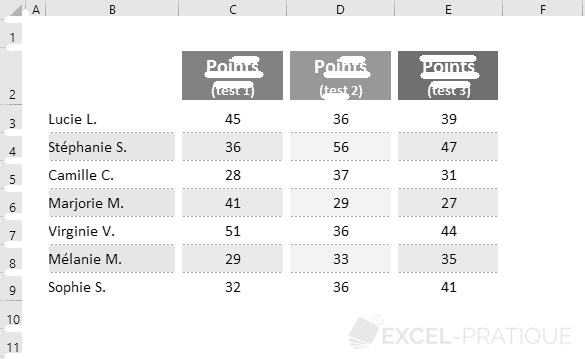

In [105]:
PILImage.fromarray(white_img)

### Image segmentation

In [93]:
img_segments = get_contours_cell(img=white_img.copy(),
                                 cell=Cell(x1=0, y1=0, x2=img.shape[1], y2=img.shape[0]),
                                 margin=0,
                                 blur_size=3,
                                 kernel_size=dpi // 10,
                                 merge_vertically=True)

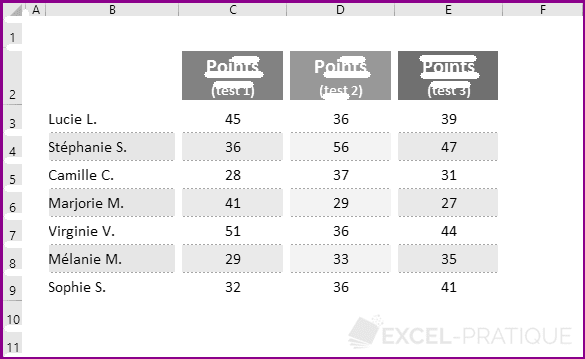

In [94]:
display_img = cv2.cvtColor(white_img.copy(), cv2.COLOR_GRAY2RGB)

for cnt in img_segments:
    cv2.rectangle(display_img, (cnt.x1, cnt.y1), (cnt.x2, cnt.y2), get_color(), 3)
PILImage.fromarray(display_img)

### Text segmentation

In [95]:
text_contours = get_contours_cell(img=white_img.copy(),
                                  cell=Cell(x1=0, y1=0, x2=img.shape[1], y2=img.shape[0]),
                                  margin=0,
                                  blur_size=3,
                                  kernel_size=dpi * 3 // 200,
                                  merge_vertically=None)

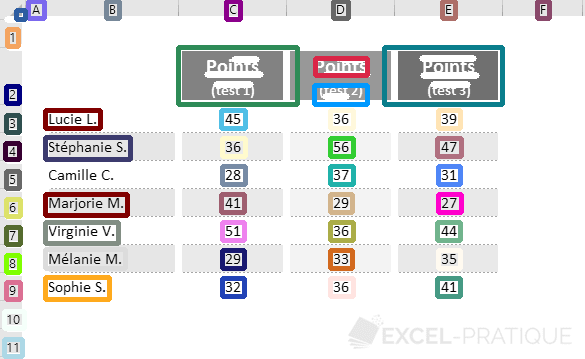

In [96]:
display_img = cv2.cvtColor(white_img.copy(), cv2.COLOR_GRAY2RGB)

for cnt in text_contours:
    cv2.rectangle(display_img, (cnt.x1, cnt.y1), (cnt.x2, cnt.y2), get_color(), 3)
PILImage.fromarray(display_img)

### Assign text contours to specific segments

In [97]:
dict_segments = {seg: [] for seg in img_segments}
for cnt in text_contours:
    # Find most likely segment
    best_segment = sorted([seg for seg in img_segments if is_contained_cell(inner_cell=cnt, outer_cell=seg)],
                          key=lambda s: s.width * s.height,
                          reverse=True).pop(0)
    dict_segments[best_segment].append(cnt)

### Manual clustering

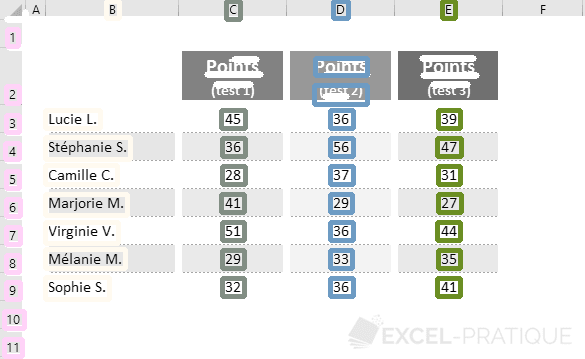

In [98]:
display_img = cv2.cvtColor(white_img.copy(), cv2.COLOR_GRAY2RGB)

def left_aligned(cell_1, cell_2):
    width = np.min([cell_1.width, cell_2.width])
    return abs(cell_1.x1 - cell_2.x1) / width < 0.1

def right_aligned(cell_1, cell_2):
    width = np.min([cell_1.width, cell_2.width])
    return abs(cell_1.x2 - cell_2.x2) / width < 0.1

def center_aligned(cell_1, cell_2):
    width = np.min([cell_1.width, cell_2.width])
    return abs(cell_1.x1 + cell_1.x2 - cell_2.x1 - cell_2.x2) / 2 * width < 0.1

def aligned_cells(cell_1, cell_2):
    return left_aligned(cell_1, cell_2) or right_aligned(cell_1, cell_2) or center_aligned(cell_1, cell_2)


width = img.shape[1]

for segment in dict_segments.values():
    cells = sorted(set(segment), key=lambda c: (c.y1, c.x1))
    
    clusters = list()
    for i in range(len(cells)):
        for j in range(i + 1, len(cells)):
            aligned = aligned_cells(cells[i], cells[j])
            # If cells are adjacent, find matching clusters
            if aligned:
                matching_clusters = [idx for idx, cl in enumerate(clusters) if {i, j}.intersection(cl)]
                if matching_clusters:
                    remaining_clusters = [cl for idx, cl in enumerate(clusters) if idx not in matching_clusters]
                    new_cluster = {i, j}.union(*[cl for idx, cl in enumerate(clusters) if idx in matching_clusters])
                    clusters = remaining_clusters + [new_cluster]
                else:
                    clusters.append({i, j})

    clusters = [merge_contours(contours=[cells[idx] for idx in cl]) for cl in clusters]
    
    # Order clusters by horizontal position
    clusters = sorted(clusters, key=lambda cl: np.mean([c.x1 + c.x2 for c in cl]))
    
    for clust in clusters:
        color = get_color()
        for cnt in clust:
            cv2.rectangle(display_img, (cnt.x1, cnt.y1), (cnt.x2, cnt.y2), color, 3)

PILImage.fromarray(display_img)

In [99]:
clusters

[[Cell(x1=7, y1=29, x2=18, y2=46, content=None),
  Cell(x1=6, y1=86, x2=19, y2=103, content=None),
  Cell(x1=6, y1=115, x2=19, y2=132, content=None),
  Cell(x1=5, y1=143, x2=19, y2=159, content=None),
  Cell(x1=6, y1=171, x2=19, y2=188, content=None),
  Cell(x1=6, y1=199, x2=20, y2=216, content=None),
  Cell(x1=6, y1=227, x2=20, y2=244, content=None),
  Cell(x1=6, y1=255, x2=19, y2=272, content=None),
  Cell(x1=6, y1=282, x2=20, y2=299, content=None),
  Cell(x1=4, y1=311, x2=24, y2=328, content=None),
  Cell(x1=4, y1=339, x2=22, y2=356, content=None)],
 [Cell(x1=106, y1=1, x2=119, y2=18, content=None),
  Cell(x1=45, y1=110, x2=100, y2=128, content=None),
  Cell(x1=45, y1=137, x2=130, y2=159, content=None),
  Cell(x1=45, y1=165, x2=117, y2=184, content=None),
  Cell(x1=45, y1=194, x2=127, y2=215, content=None),
  Cell(x1=45, y1=222, x2=118, y2=243, content=None),
  Cell(x1=45, y1=249, x2=125, y2=268, content=None),
  Cell(x1=45, y1=277, x2=109, y2=299, content=None)],
 [Cell(x1=226, y1=